<a href="https://colab.research.google.com/github/lsellers11/Quantum/blob/main/ev2asym3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

153 153
[[ 0.5 -0.5  0. ]
 [-0.5  1.  -0.5]
 [ 0.  -0.5  0.5]]
[[0.00023084 0.00011542 0.00011542]
 [0.00011542 0.00023084 0.00011542]
 [0.00011542 0.00011542 0.00023084]]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:279: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:280: ComplexWarning: Casting complex values to real discards the imaginary part


0.0005075178748755946
(-0.5802322090437997+0j)
(49.92825421449059+0j)


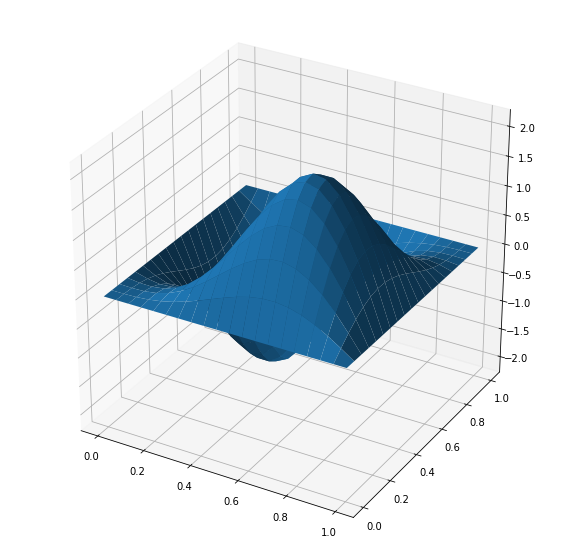

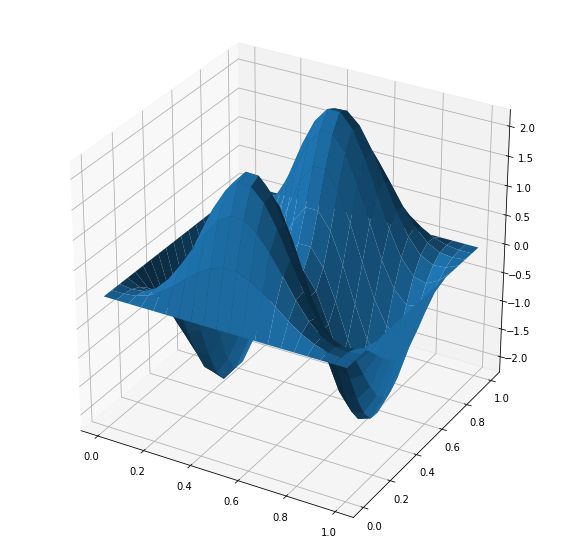

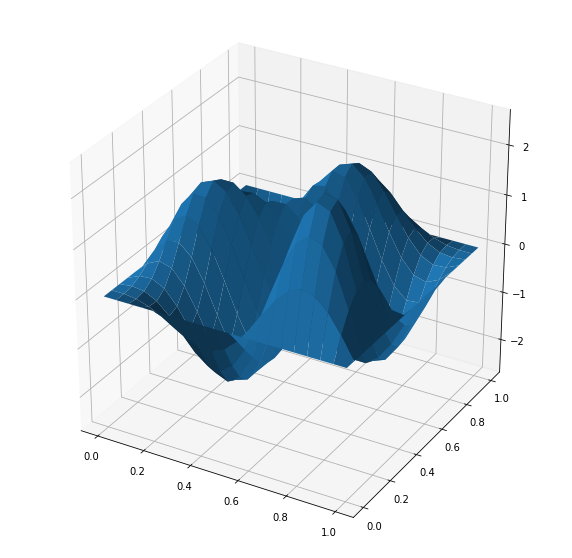

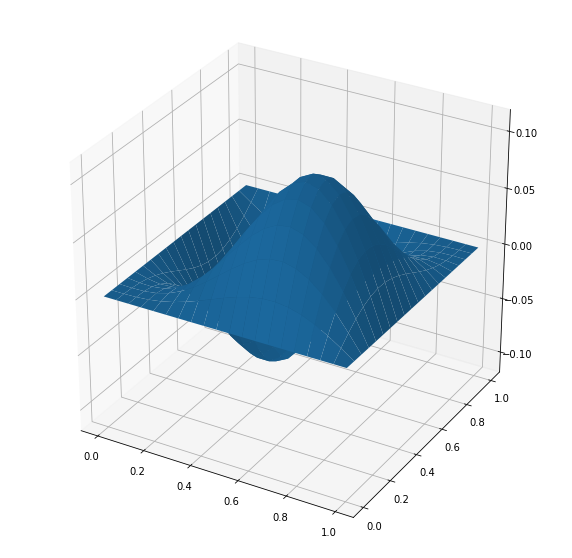

In [ ]:
import matplotlib.pyplot as plt
from sympy import *
import numpy as np
from tabulate import tabulate
import scipy.integrate as scint
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import scipy.linalg as sclalg
from mpl_toolkits.mplot3d import axes3d, Axes3D

### Grid Parameters
numevs = 3;
Lx = 1;
Ly = 1;
Nx = 20;
Ny = 20;
d = 2;
xgrid, dx = np.linspace(0, Lx, Nx, retstep = True);
ygrid, dy = np.linspace(0, Ly, Ny, retstep = True);

### Build Mesh
N = Nx*Ny;
Nt = (Nx-1)*(Ny-1)*2;
Ndets = int(Ny*(Ny-1)/2);
Ndetsnb = Ndets - ((Nx-1) + (Ny-2));

nodes = np.zeros((N, d+1), dtype=float);
nodesindices = np.zeros((N, d), dtype = int);
elem = np.zeros((Nt, d+1), dtype=int);
detnbtocoord = np.zeros((Ndetsnb, d));

### Parity Function (Note, returns 0 for same entries)
def parity(p):
  count = 0;
  L = len(p);
  for i in range(L):
    for j in range(i, L):
      if p[i] > p[j]:
        count += 1;
  return count%2;

### Check for Repeated Indices
def norepeats(p):
  L = len(p);
  thing = True;
  for i in range(L):
    for j in range(i+1, L):
      if p[i] == p[j]:
        thing = False;
  return thing;

### Bdry Check
def notonbdry(n):
  if n < Nx:
    return False;
  elif (n+1)%Nx == 0:
    return False;
  elif n%Nx == 0:
    return False;
  elif n > N-Nx:
    return False;
  else:
    return True;

### Nodes (Note, Does upper left Triangle, not lower right)
count = -1;
slatnbcount = 0;
for i in range(N):
  a = i%Nx;
  if a == 0:
    count += 1;
  nodes[i, 0] = float(a*dx);
  nodesindices[i, 0] = a;
  nodes[i, 1] = float(count*dy);
  nodesindices[i, 1] = count;
  nodes[i, 2] = 0;

  p = [a, count];
  if parity(p) == 0 and notonbdry(i) and norepeats(p): #
    nodes[i, 2] = slatnbcount;
    detnbtocoord[slatnbcount, 0] = a;
    detnbtocoord[slatnbcount, 1] = count;
    slatnbcount += 1;
print(Ndetsnb, slatnbcount)
# for i in range(N):
#   print(i, nodes[i, 2])
# print(Ndetsnb)

### Elem
count = -1;
for i in range(Nt):
  a = i%2;
  if a == 0:
    count += 1;
    if (count-(Nx-1))%Nx == 0 and count != 0:
      count += 1;
    elem[i, 0] = count;
    elem[i, 1] = count + 1;
    elem[i, 2] = count + Nx+1;
  elif a == 1:
    elem[i, 0] = count;
    elem[i, 1] = count + Nx+1;
    elem[i, 2] = count + Nx;

# for t in range(Nt):
#   print(t, elem[t,:])

### Node from Coordinate
def nodefromcoord(p):
  i = p[0];
  j = p[1];
  return i+j*Nx;

### Def Local Stiffness

# alpha funcs for midpt quad
def alphas(x):
  u = np.zeros(3);
  u[0] = 1-x[0]-x[1];
  u[1] = x[0];
  u[2] = x[1];
  return u;

def localstiffandmass(p):
  # Returnables
  Sel = np.zeros((3,3));
  # Tel = np.zeros((3,3));

  # Copout for T :(
  A = np.zeros((3,3));
  for i in range(3):
    A[i, 0] = 1;
    for j in range(1,3):
      A[i, j] = p[i, j-1];
  detA = np.linalg.det(A);

  # B Coord Trans
  B = np.zeros((2,2));
  B[0, :] = np.array(p[0, :] - p[2, :]);
  B[1, :] =  np.array(p[1, :] - p[2, :]);

  # Binv
  detB = np.linalg.det(B);
  Binv = np.zeros((2,2));
  Binv[0,0] = 1/detB*B[1,1];
  Binv[1,0] = -1/detB*B[1,0];
  Binv[0,1] = -1/detB*B[0,1];
  Binv[1,1] = 1/detB*B[0,0];

  # Reference 
  u = np.zeros((3,2));
  for i in range(3):
    u[i, :] = np.dot(B, p[i, :]) + p[2, :];

  # Midpts for Quad in ref sys
  mid0 = np.array((u[1,:]+u[2,:])/2);
  mid1 = np.array((u[2,:]+u[0,:])/2);
  mid2 = np.array((u[0,:]+u[1,:])/2);

  # Gradients
  G = np.array([[1,0], [0,1], [-1,-1]]);
  area = 0.5*detB;

  # Set Local Elements for S and T
  for i in range(3):
    if i == 0:
      for j in range(i, 3):
        # Tel[i,j] = detB * (alphas(mid1)[j] + alphas(mid2)[j]) / 6.;
        # Tel[j, i] = Tel[i, j];
        Sel[i, j] = area*np.dot(np.dot(Binv, G[i]), np.dot(Binv, G[j]));
        Sel[j, i] = Sel[i, j];
    if i == 1:
      for j in range(i, 3):
        # Tel[i,j] = detB * (alphas(mid2)[j] + alphas(mid0)[j]) / 6.;
        # Tel[j, i] = Tel[i, j];
        Sel[i, j] = area*np.dot(np.dot(Binv, G[i]), np.dot(Binv, G[j]));
        Sel[j, i] = Sel[i, j];
    if i == 2:
      for j in range(i, 3):
        # Tel[i,j] = detB * (alphas(mid0)[j] + alphas(mid1)[j]) / 6.;
        # Tel[j, i] = Tel[i, j];
        Sel[i, j] = area*np.dot(np.dot(Binv, G[i]), np.dot(Binv, G[j]));
        Sel[j, i] = Sel[i, j];

  Tel = 0.5*detA/12*np.array([[2.,1.,1.], [1.,2.,1.], [1.,1.,2.]]);
  return Sel, Tel;

p = dx*nodesindices[elem[0, :], :];
Sel, Tel = localstiffandmass(p);

print(Sel)
print(Tel)

### Transform to Bdry-Removed Index (Don't think we use for antisym)
def nobdryindex(index):
  j = index%Nx;
  i = (index-j)/Nx;
  return (i-1)*(Nx-2)+(j-1);

### Sparse Assembly (Modified for Antisymmetry)
def spassembly(nodes, elem):
  # Snumpy = np.zeros((Ndetsnb, Ndetsnb));
  # Tnumpy = np.zeros((Ndetsnb, Ndetsnb));
  spi = [];
  spj = [];
  sps = [];
  tpt = [];
  icount = 0;
  jcount = 0;
  for t in range(Nt):
    p = np.delete(nodes[elem[t, :], :], 2, axis=1);
    Sel, Tel = localstiffandmass(p);
    for ti in range(3):
      for tj in range(3):
        n1 = elem[t, ti];
        p1 = np.delete(nodes[n1,:], 2);
        q1 = nodesindices[n1, :];

        n2 = elem[t, tj];
        p2 = np.delete(nodes[n2,:], 2);
        q2 = nodesindices[n2, :];

        if notonbdry(n1) and notonbdry(n2) and norepeats(p1) and norepeats(p2):
          slatp1 = np.sort(q1); #gives first term of slat det. Working with upper left triangle
          slatp2 = np.sort(q2);
          slatn1 = nodefromcoord(slatp1); # Gets node for 1st term of slat det
          slatn2 = nodefromcoord(slatp2);

          spi.append(int(nodes[slatn1, 2])); # Gives index of slater basis
          spj.append(int(nodes[slatn2, 2]));
          fact = (-1)**(parity(p1)) * (-1)**(parity(p2));

          # Snumpy[int(nodes[slatn1, 2]), int(nodes[slatn2, 2])] = fact*Sel[ti, tj];
          # Tnumpy[int(nodes[slatn1, 2]), int(nodes[slatn2, 2])] = fact*Tel[ti, tj];
      
          sps.append(fact*Sel[ti, tj]);
          tpt.append(fact*Tel[ti, tj]);

  spi = np.array(spi, dtype=int);
  spj = np.array(spj, dtype=int);
  sps = np.array(sps, dtype=float);
  tpt = np.array(tpt, dtype=float);

  S = sp.csc_matrix((sps, (spi, spj)), shape=(Ndetsnb, Ndetsnb), dtype=float);
  T = sp.csc_matrix((tpt, (spi, spj)), shape=(Ndetsnb, Ndetsnb), dtype=float);

  return S, T;
  # return Snumpy, Tnumpy;

# for t in range(Nt):
#   p = np.delete(nodes[elem[t, :], :], 2, axis=1);
#   Sel, Tel = localstiffandmass(p);
#   for ti in range(3):
#       for tj in range(3):
#         n1 = elem[t, ti];
#         p1 = np.delete(nodes[n1,:], 2);
#         n2 = elem[t, tj];
#         p2 = np.delete(nodes[n2,:], 2);
#         if notonbdry(n1) and notonbdry(n2) and norepeats(p1) and norepeats(p2):
#           slatp1 = np.sort(p1); #gives first term of slat det
#           slatp2 = np.sort(p2);
#           slatn1 = nodefromcoord(slatp1);
#           slatn2 = nodefromcoord(slatp2);
#           print(t, n1, n2, slatn1, slatn2, nodes[slatn1, 2], nodes[slatn2, 2], parity(p1), parity(p2))


S, T = spassembly(nodes, elem);

evalues, evectors = spla.eigs(S, k = numevs, M=T, which = 'SM');

### Expand Evectors in Grid Basis from Slat Det Basis
gridevectors = [];
for n in range(numevs):
  gridev = np.zeros((Nx, Ny));
  evector = evectors[:, n];
  for k in range(Ndetsnb):
    i = int(detnbtocoord[k, 0]);
    j = int(detnbtocoord[k, 1]);
    gridev[i, j] =  evector[k];
    gridev[j, i] = -1*evector[k];
  gridevectors.append(gridev);
gridevectors = np.array(gridevectors, dtype=float);

### Exact Solutions
u10 = np.zeros(Nx*Ny);
for i in range(Nx):
  x = i*dx;
  for j in range(Ny):
    y = j*dy;
    u10[j*Nx+i] = sin(2*np.pi*x)*sin(np.pi*y) - sin(2*np.pi*y)*sin(np.pi*x);
u10 = u10 / np.linalg.norm(u10);

## Evector Vector
evectorcomp = np.zeros(Nx*Ny);
gridu10 = np.zeros((Nx, Ny));
for i in range(Nx):
  for j in range(Ny):
    evectorcomp[j*Nx+i] = gridevectors[0][i,j];
    gridu10[i,j] = u10[j*Ny+i];
evectorcomp = evectorcomp / np.linalg.norm(evectorcomp);

# ## Sign check
# p0 = evectorcomp[3];
# p1 = u10[3];
# # if p0*p1 < 0:
# #   u10 = -1*u10;
# ## Error
error = max(abs(u10-evectorcomp));
print(error)
everror = 5*np.pi**2 - evalues[0];
print(everror)
print(evalues[0])

# Plot
# xgrid = np.delete(xgrid, (0, Nx-1));
# ygrid = np.delete(ygrid, (0, Ny-1));
for n in range(numevs):
  X, Y = np.meshgrid(xgrid, ygrid);
  fig = plt.figure(figsize=(10,10));
  ax = fig.add_subplot(111, projection='3d');
  ax.plot_surface(X, Y, gridevectors[n]);
plt.show();

fig1 = plt.figure(figsize=(10,10));
ax1 = fig1.add_subplot(111, projection='3d');
ax1.plot_surface(X, Y, gridu10);
plt.show()

# # # for i in range(N):
# # #   print(nodes[i, :])
# # print(detnbtocoord)
